# Preprocessing Data

## Imports

In [1]:
import os
import glob
import pandas as pd
import numpy as np

## Per-File Preprocessing Helper

In [2]:
def preprocess_file(path):
    """
    Basic cleanup for one file:
      - parse date, sort, drop exact duplicates
      - quick dtype + date range
      - missing values report
      - duplicates & monotonicity check
      - candles per year
      - descriptive stats (numeric only)
    Returns (clean_df, summary_dict)
    """
    fname = os.path.basename(path)

    # --- load ---
    try:
        df = pd.read_csv(path)
    except Exception as e:
        return None, {"file": fname, "error": f"read_csv: {e}"}

    # normalize column names
    df.columns = [c.strip().lower() for c in df.columns]

    # keep only expected columns if present
    expected = ['date','open','high','low','close','volume']
    missing = [c for c in expected if c not in df.columns]
    if missing:
        return None, {"file": fname, "error": f"missing columns: {missing}", "columns_found": list(df.columns)}

    # reorder
    df = df[expected].copy()

    # --- parse date ---
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

    # --- initial reports BEFORE dropping anything ---
    na_counts = df.isna().sum().to_dict()
    n_dups_rows = int(df.duplicated().sum())
    n_dups_tstamps = int(df['date'].duplicated().sum())

    # --- cleanup ---
    df = df.drop_duplicates()                               # drop exact duplicate rows
    df = df.sort_values('date').reset_index(drop=True)      # sort by datetime

    # we will also drop duplicate timestamps keeping first (record how many)
    n_dups_tstamps_after_sort = int(df['date'].duplicated().sum())
    df = df[~df['date'].duplicated(keep='first')].reset_index(drop=True)

    # create a working copy without NaT dates for time-based reports
    df_valid = df.dropna(subset=['date']).copy()
    monotonic = df_valid['date'].is_monotonic_increasing

    # --- candles per year ---
    candles_per_year = df_valid.groupby(df_valid['date'].dt.year).size().to_dict()

    # --- descriptive stats (numeric only) ---
    num_cols = ['open','high','low','close','volume']
    numeric_desc = df_valid[num_cols].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).to_dict()

    # --- date range ---
    date_min = df_valid['date'].min()
    date_max = df_valid['date'].max()

    summary = {
        "file": fname,
        "rows_after_load": int(len(df)),
        "date_min": date_min,           # Timestamp (kept as Timestamp, not float)
        "date_max": date_max,
        "na_counts": {k:int(v) for k,v in na_counts.items() if v>0},
        "n_missing_total": int(sum(na_counts.values())),
        "dup_rows_initial": n_dups_rows,
        "dup_timestamps_initial": n_dups_tstamps,
        "dup_timestamps_dropped_after_sort": n_dups_tstamps_after_sort,
        "monotonic_datetime": bool(monotonic),
        "candles_per_year": candles_per_year,
        "numeric_describe": numeric_desc,  # only numeric → safe to keep as-is
        "error": None,
    }

    # return cleaned data (time-valid rows only)
    return df_valid, summary


## Preprocess Loop

In [3]:
folder = "data/nifty_100"
files = sorted(glob.glob(os.path.join(folder, "*.csv")))

all_summaries = []
cleaned_data = {}

files_processed = 0
for path in files:
    df_clean, summary = preprocess_file(path)
    all_summaries.append(summary)
    if df_clean is not None and summary.get("error") is None:
        files_processed += 1
        cleaned_data[os.path.basename(path)] = df_clean
        if files_processed % 10 == 0:
            print(f"Processed {files_processed} files...")

summary_df = pd.DataFrame(all_summaries)
summary_df.head()


""


## Visualizations and Saving the Summary DF

In [4]:

import matplotlib.pyplot as plt

# Extract number of candles per stock from summary_df
summary_df['num_candles'] = summary_df['candles_per_year'].apply(lambda d: sum(d.values()) if isinstance(d, dict) else 0)
summary_df_sorted = summary_df.sort_values('num_candles', ascending=False)

plt.figure(figsize=(16, 6))
plt.bar(summary_df_sorted['file'], summary_df_sorted['num_candles'])
plt.xticks(rotation=90)
plt.xlabel('Stock (file name)')
plt.ylabel('Number of Candles')
plt.title('Number of Candles per Stock')
plt.tight_layout()
plt.show()

KeyError: 'candles_per_year'

In [ ]:
summary_df.to_csv("data/preprocessing_summary.csv", index=False)

## Checking Clean vs. Original Diff
-  Turns out the original dataset is really clean. Yay!

In [5]:
import hashlib

def file_hash(path):
    """Quick md5 hash of entire file (bytes)."""
    with open(path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

def df_hash(df):
    """Stable hash of DataFrame content (values only, no index)."""
    return hashlib.md5(
        pd.util.hash_pandas_object(df, index=False).values
    ).hexdigest()


In [6]:
differences = []

for path in files:   # `files` from before = list of CSV paths
    fname = os.path.basename(path)
    orig_hash = file_hash(path)

    # Only check if we successfully cleaned this file
    if fname not in cleaned_data:
        continue

    # Hash cleaned DataFrame
    clean_df = cleaned_data[fname]
    clean_hash = df_hash(clean_df)

    # Reload original into DataFrame for fair comparison (parse only once!)
    orig_df = pd.read_csv(path)
    orig_df.columns = [c.strip().lower() for c in orig_df.columns]
    orig_df = orig_df[['date','open','high','low','close','volume']]
    orig_df['date'] = pd.to_datetime(orig_df['date'], errors='coerce')
    orig_df = orig_df.sort_values('date').drop_duplicates().reset_index(drop=True)
    orig_df = orig_df[~orig_df['date'].duplicated(keep='first')].reset_index(drop=True)

    orig_df_hash = df_hash(orig_df)

    differences.append({
        "file": fname,
        "orig_file_md5": orig_hash,
        "orig_df_hash": orig_df_hash,
        "clean_df_hash": clean_hash,
        "changed": orig_df_hash != clean_hash
    })

diff_df = pd.DataFrame(differences)



In [7]:
diff_df.to_csv("data/cleaned_vs_original_diff.csv", index=False)

OSError: Cannot save file into a non-existent directory: 'data'

## Labelling

In [ ]:
import pandas as pd
import numpy as np
import os

def process_file_for_returns(path: str, h: int = 1):
    """
    Cleans the raw data and calculates the raw forward return (r_h).
    DOES NOT create the label (y_h) to avoid forward-looking bias.
    
    Returns: (processed_df, summary_dict)
    processed_df columns: date, open, high, low, close, volume, r_h
    """
    fname = os.path.basename(path)
    try:
        df = pd.read_csv(path)
    except Exception as e:
        return None, {"file": fname, "error": f"read_csv: {e}"}
    
    # dropping columns r_h and y_h if they exist
    df = df.drop(columns=[c for c in ['r_h', 'y_h'] if c in df.columns], errors='ignore')

    # Normalize columns; keep only expected ones
    df.columns = [c.strip().lower() for c in df.columns]
    expected = ['date', 'open', 'high', 'low', 'close', 'volume']
    missing = [c for c in expected if c not in df.columns]
    if missing:
        return None, {"file": fname, "error": f"missing columns: {missing}", "columns_found": list(df.columns)}

    df = df[expected].copy()
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

    # Basic cleanup: drop exact duplicate rows, sort, drop duplicate timestamps
    df = df.drop_duplicates()
    df = df.sort_values('date').reset_index(drop=True)
    df = df[~df['date'].duplicated(keep='first')].reset_index(drop=True)

    # Working slice with valid dates
    dfv = df.dropna(subset=['date']).copy()

    # --- FORWARD RETURN CALCULATION ---
    # Compute forward simple return r_h = c_{t+h}/c_t - 1
    dfv['forward_close'] = dfv['close'].shift(-h)
    dfv['r_h'] = (dfv['forward_close'] / dfv['close']) - 1
    
    # Drop last h rows where the forward return is unknown (NaN)
    dfv = dfv.iloc[:-h].copy()

    # Handle tiny or degenerate series
    if len(dfv) < 100:
        return None, {"file": fname, "error": "too few rows after cleaning"}

    # --- LABELING LOGIC HAS BEEN REMOVED ---
    # The epsilon selection and `label_from_eps` calls are gone.

    # --- FINAL DATAFRAME ---
    # The output no longer contains a `y_h` column.
    out_cols = ['date', 'open', 'high', 'low', 'close', 'volume', 'r_h']
    processed_df = dfv[out_cols].copy()

    # --- UPDATED SUMMARY ---
    # Summary no longer contains info about labels or epsilon.
    sumrec = {
        "file": fname,
        "rows": int(len(processed_df)),
        "date_min": processed_df['date'].min(),
        "date_max": processed_df['date'].max(),
        "error": None
    }

    return processed_df, sumrec

In [14]:
in_folder  = "nifty_100_labeled"
out_folder = "nifty_100_labeled"
os.makedirs(out_folder, exist_ok=True)

files = sorted(glob.glob(os.path.join(in_folder, "*.csv")))
print(files)
summaries = []
written = 0
skipped = 0

for path in files:
    labeled, summary = process_file_for_returns(path, h=1)
    summaries.append(summary)

    if labeled is None or summary.get("error"):
        skipped += 1
        continue

    # write labeled CSV
    out_path = os.path.join(out_folder, os.path.basename(path))
    labeled.to_csv(out_path, index=False)
    written += 1
    if written % 10 == 0:
        print(f"Processed {written} files...")

summary_df = pd.DataFrame(summaries)
print(f"Written: {written} | Skipped (errors or too few rows): {skipped}")
summary_df.head()


['nifty_100_labeled/ABB_minute.csv', 'nifty_100_labeled/ADANIENSOL_minute.csv', 'nifty_100_labeled/ADANIENT_minute.csv', 'nifty_100_labeled/ADANIGREEN_minute.csv', 'nifty_100_labeled/ADANIPORTS_minute.csv', 'nifty_100_labeled/ADANIPOWER_minute.csv', 'nifty_100_labeled/AMBUJACEM_minute.csv', 'nifty_100_labeled/APOLLOHOSP_minute.csv', 'nifty_100_labeled/ASIANPAINT_minute.csv', 'nifty_100_labeled/AXISBANK_minute.csv', 'nifty_100_labeled/BAJAJ-AUTO_minute.csv', 'nifty_100_labeled/BAJAJFINSV_minute.csv', 'nifty_100_labeled/BAJAJHFL_minute.csv', 'nifty_100_labeled/BAJAJHLDNG_minute.csv', 'nifty_100_labeled/BAJFINANCE_minute.csv', 'nifty_100_labeled/BANKBARODA_minute.csv', 'nifty_100_labeled/BEL_minute.csv', 'nifty_100_labeled/BHARTIARTL_minute.csv', 'nifty_100_labeled/BOSCHLTD_minute.csv', 'nifty_100_labeled/BPCL_minute.csv', 'nifty_100_labeled/BRITANNIA_minute.csv', 'nifty_100_labeled/CANBK_minute.csv', 'nifty_100_labeled/CGPOWER_minute.csv', 'nifty_100_labeled/CHOLAFIN_minute.csv', 'nifty_

,file,rows,date_min,date_max,error
0,ABB_minute.csv,970887,2015-02-02 09:15:00,2025-08-06 17:22:00,None
1,ADANIENSOL_minute.csv,919750,2015-07-31 09:50:00,2025-08-06 17:54:00,None
2,ADANIENT_minute.csv,972516,2015-02-02 09:15:00,2025-08-06 17:22:00,None
3,ADANIGREEN_minute.csv,659283,2018-06-18 09:44:00,2025-08-06 17:54:00,None
4,ADANIPORTS_minute.csv,972579,2015-02-02 09:15:00,2025-08-06 17:54:00,None


In [ ]:
summary_df.to_csv("data/preprocessing_summary_labeled.csv", index=False)

## Analysis of Labelled Dataset(s)

In [ ]:
import matplotlib.pyplot as plt

# Make sure the summary_df has label counts
dist = summary_df[['file','label_-1','label_0','label_1']].copy()
dist = dist.fillna(0).astype({'label_-1':int,'label_0':int,'label_1':int})

# Sort by filename for consistent placement
dist = dist.sort_values('file').reset_index(drop=True)


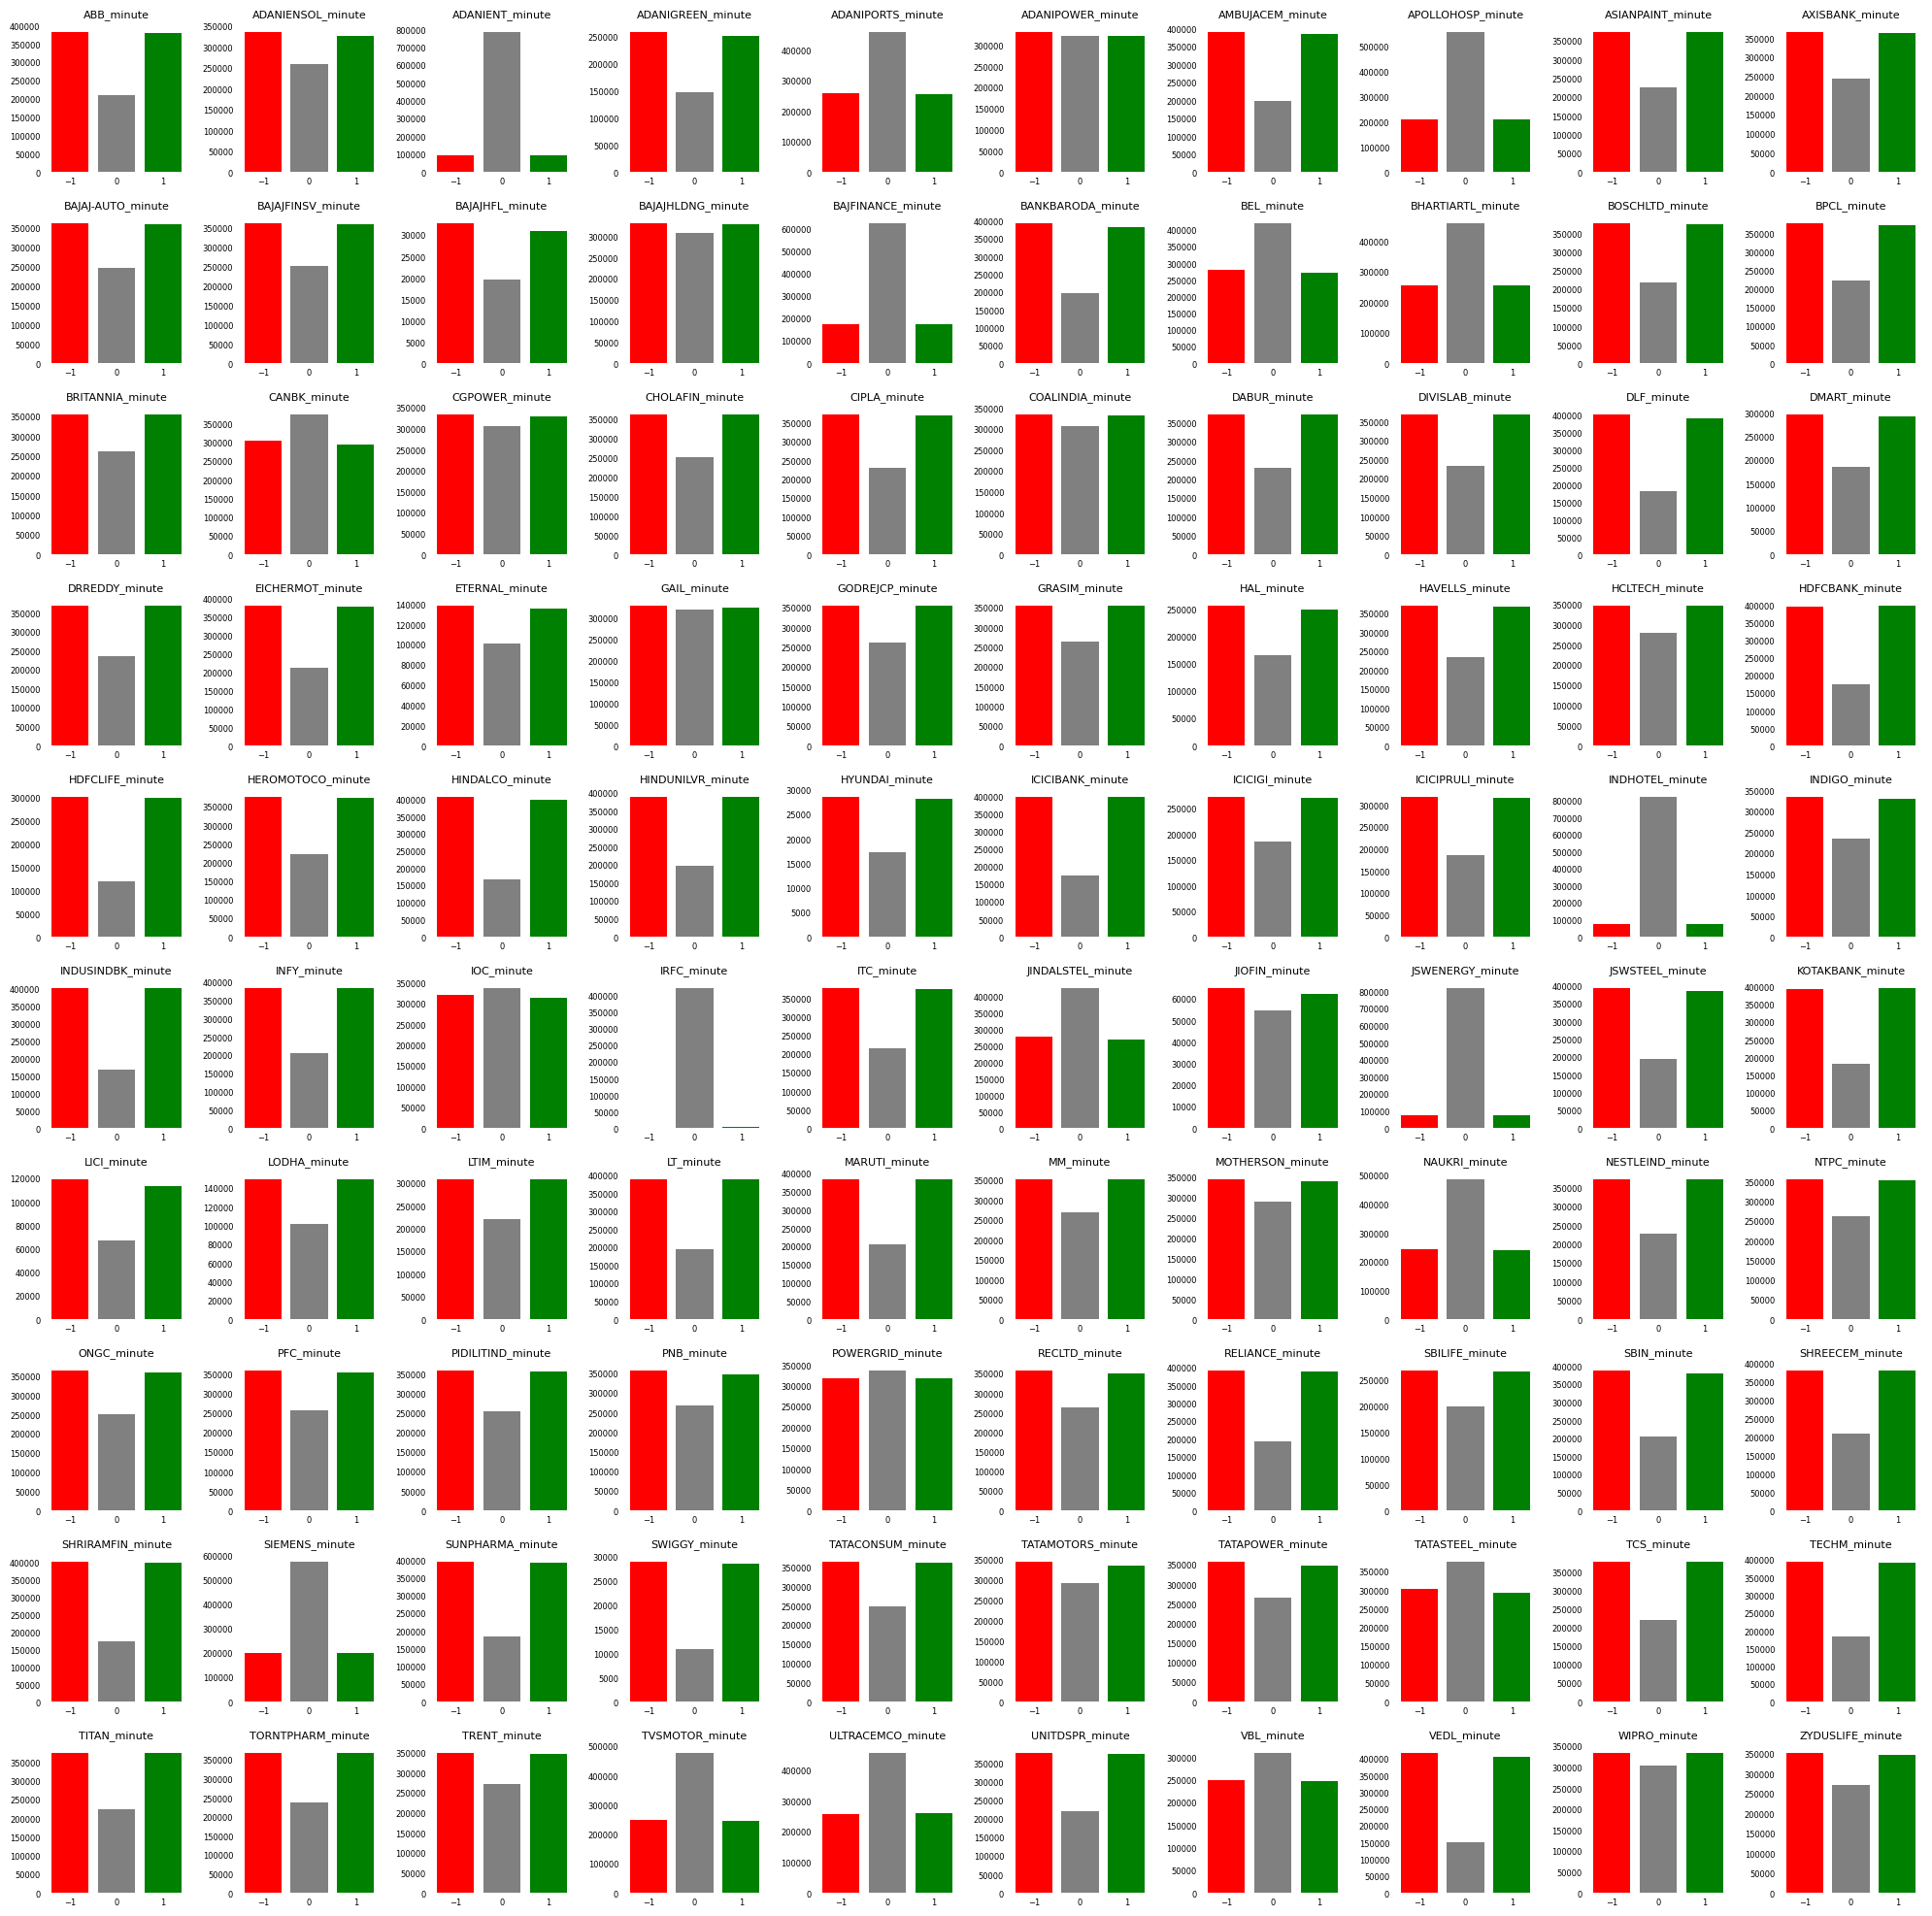

In [ ]:
n = len(dist)
cols = 10
rows = int(np.ceil(n/cols))

fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
axes = axes.flatten()

for i, row in dist.iterrows():
    ax = axes[i]
    counts = [row['label_-1'], row['label_0'], row['label_1']]
    ax.bar([-1,0,1], counts, color=['red','gray','green'])
    ax.set_title(row['file'].replace('.csv',''), fontsize=8)
    ax.set_xticks([-1,0,1])
    ax.tick_params(axis='both', which='both', length=0, labelsize=6)
    # remove spines for cleaner small multiples
    for spine in ax.spines.values():
        spine.set_visible(False)

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

# plt.suptitle("Label distribution per stock (−1, 0, 1)", fontsize=16, y=0.92)
plt.suptitle("", fontsize=16, y=0.92)
plt.tight_layout()
plt.show()
